In [17]:
import pandas as pd
import yaml
import numpy as np
# import scipy.spatial.distance.hamming as hamming
from utils.connection import _create_mysql_alchemy

In [18]:
room_features_query = '''
SELECT r.id,r.name as room_name,r.accommodates,r.bedrooms as number_of_bedrooms,
r.beds as number_of_beds, r.bathrooms as room_bath,r.amenities as room_amenities,
bt.name as bed_type, bt.status as bed_status,
pt.name as property_type,rt.description as room_type,
rl.value as room_description,
rdes.space as room_space,
rdes.access as device_access,
room_photo.cnt as number_of_photos,
rprice.night as price,
rprice.guests as number_of_guests,
calendar.last_active as last_active,
state.name as state,
city.name as city,
country.name as country,
raddress.latitude as lat,
raddress.longitude as lon

FROM sample.rooms r
left join sample.bed_type bt on r.bed_type = bt.id 
left join sample.room_type as rt on  rt.id = r.room_type 
left join sample.property_type as pt on pt.id = r.property_type
left join sample.rooms_price as rprice on rprice.room_id = r.id
left join (select rd.room_id, d.name from sample.room_destination as rd, sample.destinations as d where rd.destination_id = d.id and d.type = "state") as state on r.id = state.room_id
left join (select rd.room_id, d.name from sample.room_destination as rd, sample.destinations as d where rd.destination_id = d.id and d.type = "city") as city on r.id = city.room_id
left join (select rd.room_id, d.name from sample.room_destination as rd, sample.destinations as d where rd.destination_id = d.id and d.type = "country") as country on r.id = country.room_id
left join (select room_id, count(*) as cnt from sample.rooms_photos group by room_id) as room_photo on r.id = room_photo.room_id
left join (SELECT room_id, max(updated_at) as last_active FROM sample.calendar group by room_id) as calendar on r.id = calendar.room_id
left join rooms_description as rdes on rdes.room_id = r.id
left join rooms_address as raddress on raddress.room_id = r.id
left join sample.rooms_locales as rl on rl.room_id = r.id
--  sample.rooms_photos as rphoto
 -- sample.rooms_description as rd
where r.name != " "
and rl.name = "summary" and rl.language_code = "vi"
-- order by last_active desc
'''

In [19]:
room_amenties_query = """
select a.id as amenty_id, a.name as amenty_name, at.name as amenty_type from sample.amenities a, sample.amenities_type as at 
where a.type_id = at.id
"""

In [20]:
cnx = _create_mysql_alchemy(yaml.load(open("config_cluster.yml")))

In [21]:
df = pd.read_sql_query(sql=room_features_query,con=cnx,parse_dates=True,index_col=["id"])

In [22]:
df_amenties = pd.read_sql_query(sql=room_amenties_query,con=cnx,parse_dates=True)

## Preprocessing (Offline batching)

In [23]:
def split_text(text,delimitter=" "):
    return len(text.split(delimitter))

In [24]:
df['len_description'] = df['room_description'].map(lambda d: split_text(d) if d is not None else 0)
df['number_of_amenities'] = df['room_amenities'].map(lambda d: split_text(d,",") if d is not None else 0)

In [25]:
df['room_bath'] = df['room_bath'].fillna(0).astype(int)

In [26]:
df.sample(frac=0.3)

room_name  accommodates  number_of_bedrooms  \
id                                                                             
11438                   Phòng ngủ Princess           4.0                 1.0   
11639   Esperanto -Japanese Style Studio 2           2.0                 1.0   
11482  Park View 1 Bedroom Serviced Apartm           2.0                 1.0   
10042                            210ICON56           6.0                 3.0   
10094           FLAMINGO 2PN KHU HOÀNG ANH          15.0                 3.0   
11619   Vinhomes Central Park 1 phòng ngủ            2.0                 1.0   
11457  Luxstay's Modern Aparment in Vinhom           7.0                 3.0   
10098            Feels Like Home Apartment           6.0                 3.0   
11551                        Icon 56 - 509           3.0                 1.0   
11685  Audrey's Villa Phu Quoc - Sebastian           2.0                 1.0   
11688                  Peace Room Phú Quốc           2.0                 1.0   
10004        Chateaux Apartment West Lake            4.0                 1.0   
10016                      Thái 1 ngủ đẹp            4.0                 1.0   
11554                      Icon 56 - 1112B           3.0                 1.0   
11489    Riverside Lan'd Villa 2 in Hoi An           8.0                 3.0   
11627                     Hang Khay tang 2           2.0                 0.0   
11664                         Autumn Villa          10.0                 3.0   
10110    An Bang Garden House - Daisy Room           2.0                 1.0   
10089                                COPAC           6.0                 2.0   
10032                 HCMQ3_TruongDinhR705           6.0                 2.0   
10075           Gorgeous Villa in Vũng Tàu          12.0                 4.0   
11452      AZURA SCENIC PANORAMA APARTMENT           7.0                 2.0   
10065                         HOANGDIEU603           2.0                 0.0   
11587            Lafiesta Apartment - 1 BR           3.0                 1.0   
11662                        số 10 Đỗ Hành           3.0                 1.0   
11494  An-Villa Samma Garden River View Vi           4.0                 2.0   
10003             Brika Handmade Apartment           6.0                 2.0   
10076    Waterloo Sunset Villa in Vũng Tàu          15.0                 4.0   
10025                      HCM_Icon56R2205           4.0                 2.0   
11568                         Retro Studio           3.0                 1.0   
...                                    ...           ...                 ...   
11569                  Saigon Fusion Place           6.0                 2.0   
10067           156 Triệu Việt Vương - 702           4.0                 2.0   
11528                      The Point Villa          10.0                 3.0   
10095              Flamingo khu Bách Thanh           8.0                 3.0   
11615           Mie House - Lovely Studio            3.0                 1.0   
11694                   Indochine House L3           3.0                 1.0   
11574                 La casa de Mi - Boho           4.0                 1.0   
11687                 Peace House Phú Quốc          10.0                 4.0   
11521       La Casa Nam Ngu - The Hideaway           4.0                 1.0   
11668                       aloha 2 giường           2.0                 0.0   
11493   An-Villa Sukkha Garden View studio           3.0                 0.0   
11580                  Mountain Side Villa           4.0                 2.0   
11480         Timescity Familiae Apartment           7.0                 3.0   
11442                 Ngoc Khanh Apartment           7.0                 3.0   
11490     An-Villa Metta Pool View studio            2.0                 1.0   
11593                       Rustic House 2           3.0                 1.0   
11818            Imperia Garden Apartment            4.0                 2.0   
10086         Homestay Bình Quớ

## Unstack amenties type

In [27]:
amenties = []
for aid, value in df[~df['room_amenities'].isna()]['room_amenities'].iteritems():
    for item in value.split(","):
        amenties.append([aid,int(item)])

In [28]:
df_amenties_unstack = pd.DataFrame(amenties,columns=['room_id','amenty_id'])

In [29]:
df_join_amenties_unstack = df_amenties_unstack.merge(df_amenties,on='amenty_id').set_index('room_id')

In [30]:
df_room_amenties_unstack = df_join_amenties_unstack.merge(df,left_index=True,right_index=True)

In [31]:
df_room_amenties_unstack.head()

amenty_id    amenty_name         amenty_type           room_name  \
10002          5            BBQ  Hoạt động giải trí  Green Ribbon Villa   
10002          6       Bếp điện        Tiện ích bếp  Green Ribbon Villa   
10002          7     Lò vi sóng        Tiện ích bếp  Green Ribbon Villa   
10002          8        Tủ lạnh        Tiện ích bếp  Green Ribbon Villa   
10002         10  Cảnh quan đẹp  Hoạt động giải trí  Green Ribbon Villa   

       accommodates  number_of_bedrooms  number_of_beds  room_bath  \
10002          15.0                 5.0             7.0          5   
10002          15.0                 5.0             7.0          5   
10002          15.0                 5.0             7.0          5   
10002          15.0                 5.0             7.0          5   
10002          15.0                 5.0             7.0          5   

                                          room_amenities  bed_type  \
10002  5,6,7,8,10,13,17,22,27,36,37,38,39,41,42,44,45...  Real Bed   
10002  5,6,7,8,10,13,17,22,27,36,37,38,39,41,42,44,45...  Real Bed   
10002  5,6,7,8,10,13,17,22,27,36,37,38,39,41,42,44,45...  Real Bed   
10002  5,6,7,8,10,13,17,22,27,36,37,38,39,41,42,44,45...  Real Bed   
10002  5,6,7,8,10,13,17,22,27,36,37,38,39,41,42,44,45...  Real Bed   

              ...         price number_of_guests         last_active  \
10002         ...           499               10 2017-06-14 08:03:11   
10002         ...           499               10 2017-06-14 08:03:11   
10002         ...           499               10 2017-06-14 08:03:11   
10002         ...           499               10 2017-06-14 08:03:11   
10002         ...           499               10 2017-06-14 08:03:11   

          state       city  country        lat                 lon  \
10002  Hòa Bình  Lương Sơn  Vietnam  20.871913  105.50402689999999   
10002  Hòa Bình  Lương Sơn  Vietnam  20.871913  105.50402689999999   
10002  Hòa Bình  Lương Sơn  Vietnam  20.871913  105.50402689999999   
10002  Hòa Bình  Lương Sơn  Vietnam  20.871913  105.50402689999999   
10002  Hòa Bình  Lương Sơn  Vietnam  20.871913  105.50402689999999   

       len_description number_of_amenities  
10002               58                  23  
10002               58                  23  
10002               58                  23  
10002               58                  23  
10002               58                  23  

[5 rows x 27 columns]

In [32]:
# df.to_sql(con=cnx,name="room_feature",if_exists="append")

# Quick glance

In [33]:
import matplotlib.pyplot as plt
import seaborn as snb

Answer the question:
- How many rooms?
- Distribution of location
- Distribution of price
- Distribution of bed_type
- Distribution of property
- Distribution of room_type
- Average photos per each room
- Average amenities

## How many rooms

In [34]:
print(len(df))

348


## Distribution of location

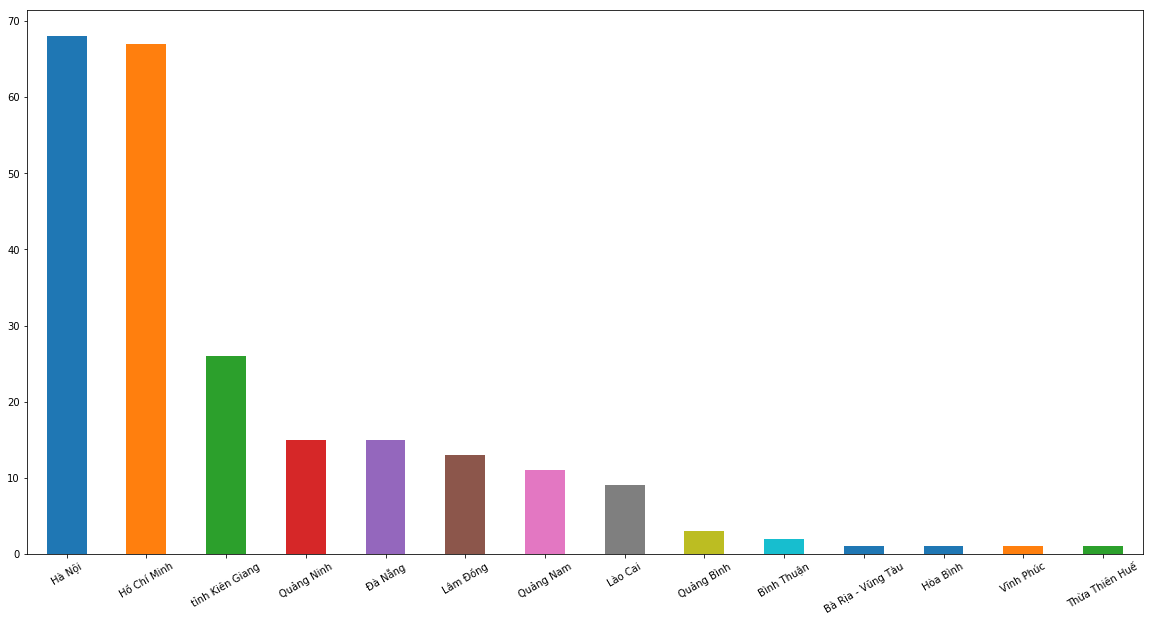

In [35]:
df[~df.state.isna()]['state'].value_counts().plot(kind="bar",rot=30,figsize=(20,10))

## Distribution of price

In [36]:
df['log_price'] = np.log(df['price'])
price_large = df['price'].quantile(q=0.96)

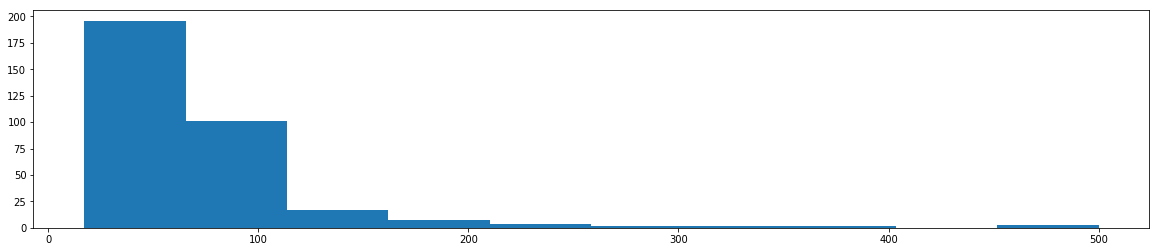

In [37]:
df[df['price']<=price_large]['price'].hist(grid=False,figsize=(20,4))

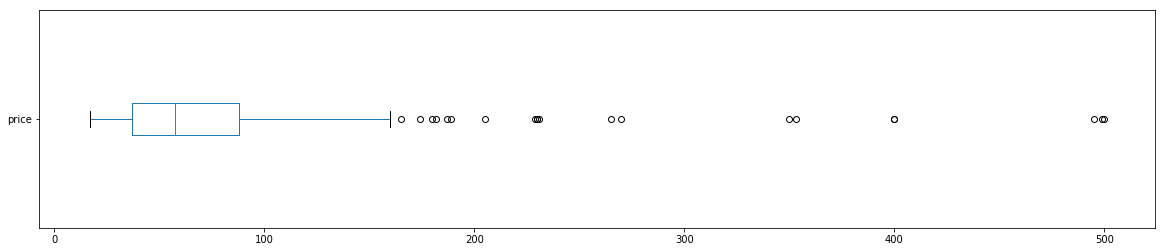

In [38]:
df[df['price']<price_large]['price'].plot.box(grid=False,figsize=(20,4),vert=False)

In [39]:
df_room_amenties_unstack.groupby(['property_type'])['num_amenties'].mean().plot(kind="barh", figsize=(20,4))

KeyError: 'Column not found: num_amenties'

In [ ]:
not_top_amenties = df_room_amenties_unstack['amenty_name'].value_counts()[10:]

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1,)
for idx,property_type in enumerate(df_room_amenties_unstack.property_type.unique()):
    df_room_amenties_unstack[(df_room_amenties_unstack['property_type']==property_type)&(df_room_amenties_unstack['amenty_name'].isin(not_top_amenties.index))]['amenty_name']\
            .value_counts()[:10].plot(kind="barh", figsize=(30,30),fontsize=12,\
                                      title="Top amenties on %s"%property_type,ax=axes[idx])

# Building Room Features

In [ ]:
onehot_room_cols = ["bed_type","bed_status","property_type","room_type"]
onehot_room_address = ["state","city","country"] 

In [ ]:
number_of_amenties = df_amenties['amenty_id'].max()

In [ ]:
def building_features(text_vec, number_of_amenties):
    vector = [0] * (number_of_amenties)
    if text_vec is not None:
        for i in text_vec.split(","):
            vector[int(i)-1] = 1
    return np.array(vector)
def hamming_distance(s1,s2):
    count = 0
    for i in range(len(s1)):
        if s1[i]==s2[i]:
            count+=1
    return count*1.0/len(s1)
def haversine_distance(s1,s2):
    if isinstance(s1,tuple) and isinstance(s2,tuple):
        R = 6371e3
        delta = np.deg2rad(s2[0] - s1[0])
        gamma = np.deg2rad(s2[1] - s1[1])
        rad_lat1 = np.deg2rad(s1[0])
        rad_lat2 = np.deg2rad(s2[0])
        
        a = np.square(np.sin(delta/2)) + np.cos(rad_lat1) * np.cos(rad_lat2) * np.square(np.sin(gamma/2))
        c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1-a))
        d = R * c
        return d

In [ ]:
s1 = (10.815290715988,106.73022562892)
s2 = (10.8001392,106.7173156)

In [ ]:
haversine_distance(s1,s2)/1000

In [ ]:
df['vector'] = df['room_amenities'].map(lambda d: building_features(d,number_of_amenties))

In [ ]:
vectors = df['vector'].values

In [ ]:
sample = vectors[0]

In [ ]:
hamming_distance(vectors[1],sample)

In [ ]:
candidates = []
for i in range(1,len(vectors)):
    if vectors[i] is not None:
        candidates.append((i,hamming_distance(vectors[i],sample)))

In [ ]:
df_candidates = pd.DataFrame(candidates,columns=['name','score'])

In [ ]:
df_candidates.sort_values(by=['score'],ascending=False)[0:10]

In [ ]:
df.iloc[72]

In [ ]:
df.iloc[0]